In [1]:
import bibtexparser
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from pybtex.database import parse_file

### 1. Planejamento: Definição da Questão de Pesquisa

### 2. Planejamento: Desenvolvimento do Protocolo de Revisão

Bases de dados consultadas para exportação dos arquivos bibtex:

- OpenAlex - https://openalex.org/
- ACM Digital Library - http://dl.acm.org
- Elsevier Science Direct - https://www.sciencedirect.com/search/entry
- Engineering Village El Compendex - https://www.engineeringvillage.com
- IEEE Xplore Digital Library - https://ieeexplore.ieee.org
- Scopus - https://www.scopus.com/search/form.uri
- Web of Science - https://www.webofscience.com/wos/woscc/united-search

Todos bibtext foram exportados na data: xx/xx/2024

String de busca aplicado somente no título e no resumo: <code>"Dashboard" AND "Learning Analytics" AND ("Systematic Literature Review" OR "Systematic Review")</code>

Problemas encontrados na exportação para bibtex de cada plataforma:

<br><b>OpenAlex:</b> <br>

Só exporta no formato ris. Com a biblioteca pybtexris convertemos para bibtex com o comando <code>pybtex-convert openalex.ris openalex.bib</code>. Por conta da duplicação das chaves no arquivos ris: 
<code>
WARNING: repeated bibliograhpy entry: Schwendimann2016                                                                                  
WARNING: repeated bibliograhpy entry: Kaliisa2023
</code>

Editei manualmente o arquivo ris, dupliquei a linha do autor (AU) de umas das entradas e criei uma linha com ID único:
<code>
AU  - Schwendimann, Beat
ID  - Schwendimann1 ---> Nova linha
...
AU  - Kaliisa, Rogers
ID  - Kaliisa1 ---> Nova linha
</code>

Com essas alterações o comando <code>pybtex-convert openalex.ris openalex.bib</code> foi rodado com sucesso.

<br><b>ACM Digital Library:</b><br>

descrever problema

<br><b>Elsevier Science Direct:</b><br>

descrever problema


<br><b>Engineering Village El Compendex:</b><br>

Tive que remover manualmente "copyright = {Compendex}," no arquivo engineering_village.bib
<code>sed -i 's/copyright = {Compendex},//g' engineering_village.bib</code>

<br><b>IEEE Xplore Digital Library:</b> <br>
escrever problema


<br><b>Scopus:</b><br>

Na scopus há itens com a chave duplicada no bibtex, que foram identificados com o comando:
<code>cat scopus.bib | grep ^@ | cut -d'{' -f2 | sort | uniq --count | sort</code>

Foi necessário corrigir o bibtex na mão os itens com a chave 2020 e 2024

<br><b>Web of Science:</b><br>

descrever problema


In [23]:
# Vamos colocar todos artigos em um único dataframe para extrais as métricas desejadas.

df = pd.DataFrame(columns=['database','identifier','title','year'])
def insert_references_on_dataframe(database,filepath,df):
    """ Função que lê as entradas em bibtex de cada database e devolve os campos que queremos em um dataframe """
    text = Path(filepath).read_text()
    text_library = bibtexparser.parse_string(text)
    references = []
    for entry in text_library.entries:
        new_dict = {}
        new_dict['database'] = [database]
        new_dict['identifier'] = entry.key
        for key, value in entry.items():
            #print(key,': ', value)
            if key in ['title','year']:
                new_dict[key] = [value]
        new_line = pd.DataFrame(new_dict)
        df = pd.concat([df, new_line], ignore_index = True)
    return df

In [24]:
data_path = '../data/doutorado/tertiary_review/bibtex/'

# OpenAlex
df = insert_references_on_dataframe('openalex', data_path + 'openalex.bib',df)

# ACM Digital Library
df = insert_references_on_dataframe('acm', data_path + 'acm.bib',df)

# Elsevier Science Direct
df = insert_references_on_dataframe('science direct', data_path + 'science_direct.bib',df)

# Engineering Village El Compendex
df = insert_references_on_dataframe('engineering village',data_path + 'engineering_village.bib',df)

# IEEE Xplore Digital Library
df = insert_references_on_dataframe('ieee',data_path + 'ieee.bib',df)

# Scopus
df = insert_references_on_dataframe('scopus',data_path + 'scopus.bib',df)

# Web of Science
df = insert_references_on_dataframe('web of science',data_path + 'web_of_science.bib',df)

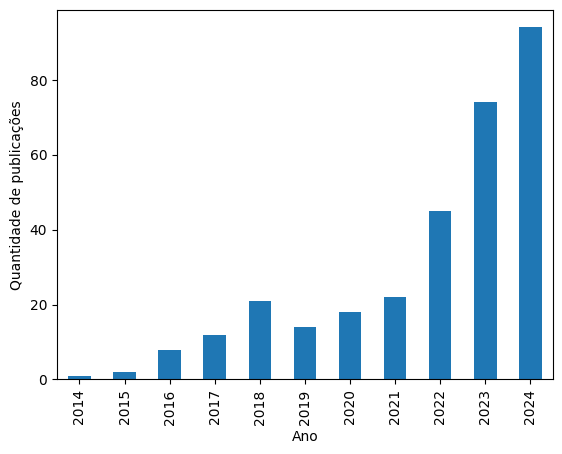

In [26]:
# Agrupando por ano
df_yearly = df.groupby('year').size()
ax = df_yearly.plot.bar()
ax.set_xlabel("Ano")
ax.set_ylabel("Quantidade de publicações")
plt.savefig('../output/doutorado/tertiary_review_yearly_barplot.pdf')

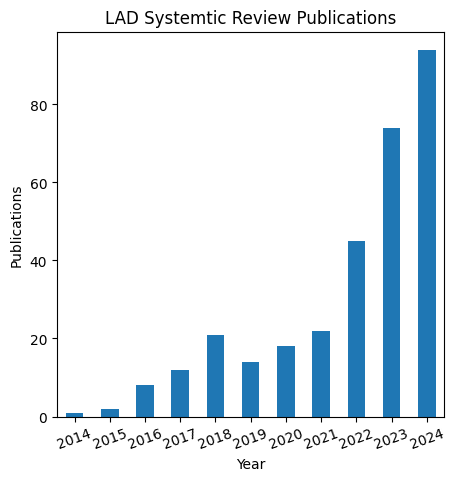

In [28]:
# a english version
df_yearly = df.groupby('year').size()
ax = df_yearly.plot.bar(title='LAD Systemtic Review Publications', figsize=(5, 5))
ax.set_xlabel("Year")

# rotacionando os anos
ax.set_xticklabels(df_yearly.index,rotation=20)

ax.set_ylabel("Publications")
plt.savefig('../output/tertiary_review_yearly_barplot_en.pdf')

In [32]:
# Salvando tabela em .tex
tertiary_review_databases = df.groupby('database').size().sort_values(ascending=False)
tertiary_review_databases = pd.DataFrame(tertiary_review_databases)
tertiary_review_databases.reset_index(inplace=True)
tertiary_review_databases.columns = ['Bases Selecionadas','Quantidade de publicações']

# soma
soma = tertiary_review_databases['Quantidade de publicações'].sum()
new_row = pd.DataFrame({'Bases Selecionadas': ['Soma'], 'Quantidade de publicações':[soma]})
tertiary_review_databases = pd.concat([tertiary_review_databases, new_row], axis=0, ignore_index=True)
tertiary_review_databases

,Bases Selecionadas,Quantidade de publicações
0,acm,113
1,science direct,99
2,scopus,40
3,openalex,33
4,engineering village,22
5,web of science,18
6,ieee,4
7,Soma,329


Dos 329 artigos, o parsifal detectou 63 como duplicados

In [30]:
# Salvando tabela em .tex
latex_code = pd.DataFrame(tertiary_review_databases).style.hide().to_latex(
    column_format="c|c", 
    position="H",
    label="table:tertiary_review_databases", 
    caption="Quantidade de publicações selecionadas em cada base",
    hrules=True, # necessita de \usepackage{booktabs},
    convert_css=True
) 

# manobra para colocar um linha horizontal antes da soma
latex_code_lines = latex_code.splitlines()
last_row_index = len(latex_code_lines) - 4
latex_code_lines.insert(last_row_index, '    \\hline')
modified_latex_code = '\n'.join(latex_code_lines)

with open('../output/tertiary_review_databases.tex', 'w') as the_file:
    the_file.write(modified_latex_code)

## 3. Planejamento: Definição dos critérios de inclusão e de exclusão

Neste trabalho vamos usar somente critérios de exclusão, que são: 

- Texto duplicado
- Estudo duplicado (descartado pois foi escolhido o texto mais recente e completo)
- É um estudo primário sobre LAD e não uma revisão sistemática 
- É um estudo primário não relacionado a Learning Analytics ou LAD
- É uma revisão sistemática em Learning Analytics, mas não focada apenas em LAD
- É uma revisão sistemática não relacionada a Learning Analytics ou LAD
- Não temos acesso ao texto completo

## 4. Condução Busca Sistemática e Seleção de Estudos



    

    
    


## 5. Condução: Extração de Dados

    
- Agentes educacional do LAD: estudantes, docentes, gestores, técnicos e sociedade
- Quais bases de dados foram consultadas
- Em qual ano os artigos foram coletados para a revisão sistemática?
- Qual ferramenta foi utilizada para a revisão sistemática?
- Número de artigos inicialmente selecionados?
- Número de artigos incluídos na análise final?
- Contexto de uso do LAD: Aula presencial usando LMS como suporte, Ensino remoto, MOOC ou Não Especificado.


## 6. Condução: Síntese e Análise dos Dados

- Não foram em nenhum aspecto em particular de LAD: 6
- Avalaliaram se houve fundamentos teóricos educacionais na implementação do LAD: 6
- Avalaliaram efetividade no ganho educacional com LAD: 2
- Avalaliaram LAD implementados com uso de Aprendizado de Máquina: 1


## 7. Condução: Avaliação da Qualidade

- A metodologia usada na revisão sistemática foi descrita de forma completa e clara?
- O artigo fornece informações para torna-lo reprodutível?
- O artigo informa se uma ferramenta de suporte foi utilizada na revisão sistemática?
- O artigo deixa claro os agentes educacionais alvo do LAD?
- O artigo indica o intervalo de tempo considerado para a seleção dos estudos?


## 8. Resultados: Interpretação dos Resultados


## 9. Resultados: Relato dos Resultados